# Hamiltonian Identification as Polynomial Optimization

This notebook uses multithreadin. Set  

    export JULIA_NUM_THREADS=100
   
before runing Julia

In [1]:
Threads.nthreads()

10

In [2]:
using LinearAlgebra
using QuantumOptics
using DynamicPolynomials, MomentTools
using TSSOS
using QuadGK
using MosekTools
using JuMP
using Random
using NLopt

## Quantum system

In [3]:
#= 
Quantum system is taken from 
 https://github.com/q-optimize/c3/blob/master/examples/two_qubits.ipynb

Drift Hamiltonian
=#

H0 = [
    0 0 0;
    0 3.21505101e+10 0;
    0 0 6.23173079e+10
];

H0 ./= norm(H0, Inf)

# Control Hamiltonian
V_exact = [
    0 1 0;
    1 0 1.41421356;
    0 1.41421356 0
]

V_exact ./= norm(V_exact, Inf);

In [4]:
H0

3×3 Matrix{Float64}:
 0.0  0.0       0.0
 0.0  0.515916  0.0
 0.0  0.0       1.0

In [5]:
V_exact

3×3 Matrix{Float64}:
 0.0       0.707107  0.0
 0.707107  0.0       1.0
 0.0       1.0       0.0

In [6]:
# the unknown to be found
@polyvar z[1:2]

# its exact value
const z_exact = [V_exact[1, 2], V_exact[2, 3]]

V_known = [
    0 z[1] 0;
    z[1] 0 z[2];
    0 z[2] 0
]

3×3 Matrix{Term{true, Int64}}:
 0   z₁  0
 z₁  0   z₂
 0   z₂  0

## Utilities for working with Polynomials

In [7]:
function ∫(p::AbstractPolynomial, x::PolyVar, x_lower, x_upper)
    
    # get the index of the variable of integration
    ind_x = indexin([x], variables(p))[1]
        
    if isnothing(ind_x)
        # integration valuable is not found among vars
        return p * (x_upper - x_lower)
    end
    
    # get the indefinite integral
    int_p = sum(
        term * x * 1 // (exponents(term)[ind_x] + 1) for term in terms(p)
        init = 0 * x
    )
            
    # get the definite integral
    subs(int_p, x=>x_upper) - subs(int_p, x=>x_lower)
end

function ∫(M::AbstractMatrix, x::PolyVar, x_lower, x_upper)
   map(z -> ∫(z, x, x_lower, x_upper), M) 
end

function real_poly(p::Polynomial)
    #=
    Real part of the polynomial
    =#
    sum(
        real(c) * m for (c, m) in zip(coefficients(p), monomials(p))# if ~isapproxzero(abs(c))
    )
end

function square_frobenius_norm(M::AbstractArray)
    #=
    Square of the Frobenius norm of a matrix
    =#
    real_poly(sum(z' * z for z in M))
end

square_frobenius_norm (generic function with 1 method)

## Get the truncated Magnus expansion ($n=3$)

In [8]:
@polyvar x[1:3]
@polyvar t[1:3]

# final time
const T = 0.5

function u(t, x)
    # the polynomial shape for control
    sum(x[n] * t^(n - 1) for n = 1:length(x))
end

function A(t, x)
    #=
    The generator of motion entering the Magnus expansion
    =#
    (H0 + V_known * u(t, x)) / im
end

function commutator(a, b)
    a * b - b * a
end 

# get the partial sum of the Magnus expansion
A₁ = A(t[1], x)
A₂ = A(t[2], x)

Ω = ∫(A₁, t[1], 0, T);

# 2nd term in the Magnus expansion
Ω .+= 1//2 * ∫(∫(
    commutator(A₁, A₂), 
    t[2], 0, t[1]), 
    t[1], 0, T
);

# 3nd term in the Magnus expansion

A₃ = A(t[3], x)

Ω .+= 1//6 * ∫(∫(∫(
    commutator(A₁, commutator(A₂, A₃)) + commutator(commutator(A₁, A₂), A₃),
    t[3], 0, t[2]),
    t[2], 0, t[1]),
    t[1], 0, T
);

## Chebyshve polynomial approximation for $\exp(\Omega/2)$

In [9]:
using SpecialFunctions

"""
Chebyshev approximation for exp(Ω/2)
"""
function exp_chebyshev(Ω::AbstractMatrix, order::Integer)
    
    Tₙ₋₁ = I
    Tₙ  = Ω
    
    # The first two terms of Chebyshev series for exp
    series = besselj(0, 0.5) * Tₙ₋₁ + 2 * besselj(1, 0.5) * Tₙ
    
    for n=2:order
        Tₙ₊₁  = 2 * Ω * Tₙ + Tₙ₋₁
        
        series .+= 2 * besselj(n, 0.5) * Tₙ₊₁
        
        (Tₙ, Tₙ₋₁) = (Tₙ₊₁, Tₙ) 
    end
    
    series
end

Ω = convert(typeof(A₁), Ω)

exp½Ω = exp_chebyshev(Ω, 5);

### Old: Construct the polynomial $\tanh_p \frac{\Omega^{(n)}}{2}$ with $n=3$ and $p=5$

## Getting statistic for checking the performance of quantum control formulation as a polynomial optimization

In [10]:
function get_unitray(x::AbstractArray, V::Matrix)
    #=
    Get the unitary given the coefficients for the polynomial control
    =#
    basis = NLevelBasis(size(H0)[1])

    𝓗₀ = DenseOperator(basis, basis, H0)
    𝓥 = DenseOperator(basis, basis, V)

    H = LazySum([1., u(0, x)], [𝓗₀, 𝓥])
        
    function 𝓗(t, psi)
        H.factors[2] = u(t, x)
        return H
    end

    _, 𝓤 = timeevolution.schroedinger_dynamic([0, T], identityoperator(basis, basis), 𝓗)
    
    return Matrix(𝓤[2].data)
end


function local_minimize(obj::AbstractPolynomial, init_x::AbstractArray)
    #=
    Perform local minimization of obj polynomial using init_x as initial guess
    =#
    vars = variables(obj)

    @assert length(vars) == length(init_x)
    
    function g(a...)
        # Converting polynomial expression to function to be minimize
        obj(vars => a)
    end
    
    model = Model(NLopt.Optimizer)

    set_optimizer_attribute(model, "algorithm", :LD_MMA)

    set_silent(model)
    @variable(model, y[1:length(vars)])

    # set initial guess
    for (var, init_val) in zip(y, init_x)
        set_start_value(var, init_val)
    end

    register(model, :g, length(y), g; autodiff = true)
    @NLobjective(model, Min, g(y...))
    JuMP.optimize!(model)

    map(value, y)
end

local_minimize (generic function with 1 method)

In [11]:
@time begin
    
n_samples = 1000
Random.seed!(6292022)

# randomly generate the coefficients for the polynomial control 
# to determine z
try_x = -1 .+ 2 * rand(length(x) * n_samples)
try_x = reshape(try_x, (length(x), n_samples))

# The values of objective functions for exact value of parameter z
obj_z_exact = zeros(n_samples)

# the estimate of the global minimum of the polynomial objective function using MomentTools
glob_obj_min = zeros(n_samples)

# The global minimum via TSSOS library
tssos_glob_obj_min = zeros(n_samples)

# difference between recovered and exact z
norm_diff_z = zeros(n_samples)
    
# Testing the accuracy of the Magnus expansion
norm_U_target_minus_expΩ_min_z = zeros(n_samples)
norm_U_target_minus_expΩ_z_exact = zeros(n_samples)

Threads.@threads for i=1:n_samples
    
    # target unitray
    U_target = get_unitray(try_x[:, i], V_exact)
    
    # get the polynomial objective function
    
    exp½Ω_x = subs(exp½Ω, x => try_x[:, i])
    obj = square_frobenius_norm(
        #I - U_target + (I + U_target) * subs(tanh₅, x => try_x[:, i])
        exp½Ω_x' *  U_target - exp½Ω_x
    )
    
    # save the value of objective function for exact x
    obj_z_exact[i] = obj(z_exact)
    
    # Perform polynomial optimization using MomentTools
    optimizer = optimizer_with_attributes(Mosek.Optimizer, "QUIET" => true)
    glob_obj_min[i], M = minimize(obj, [], [], variables(obj), maxdegree(obj) ÷ 2, optimizer)
    
    # Extract the estimate for the global minimum 
    r = get_minimizers(M)
    obj_min_vals = [obj(r[:, j]) for j=1:size(r)[2]]
    min_z = r[:, argmin(obj_min_vals)]
        
    # refine the estimate by local minimization
    min_z = local_minimize(obj, min_z)
    
    norm_diff_z[i] = norm(min_z - z_exact)
    
    # Testing the accuracy of the Magnus expansion
    Ω_min_z = convert(Matrix{ComplexF64}, subs(Ω, x => try_x[:, i], z => min_z))
    norm_U_target_minus_expΩ_min_z[i] = norm(U_target - exp(Ω_min_z))
        
    Ω_z_exact = convert(Matrix{ComplexF64}, subs(Ω, x => try_x[:, i], z => z_exact))
    norm_U_target_minus_expΩ_z_exact[i] = norm(U_target - exp(Ω_z_exact))
end
    
end

124.557131 seconds (1.20 G allocations: 146.867 GiB, 15.84% gc time, 65.21% compilation time)


## Saving results

## Analysis

In [12]:
using Plots
using LaTeXStrings

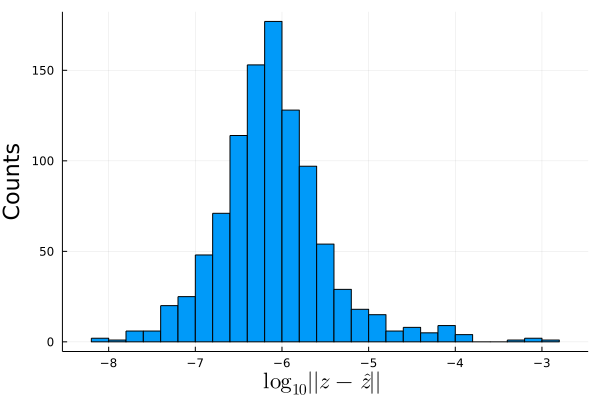

In [74]:
histogram(
    log10.(norm_diff_z), 
    label=nothing, 
    xlabel=L"\log_{10}||z - \hat{z}||", 
    ylabel="Counts",
    guidefontsize=15,
    #tickfontsize=15
)
#savefig("Fig_ZexactVsZrecovered.pdf")

### Actual global minimum vs global minimum estimate via MomentTools

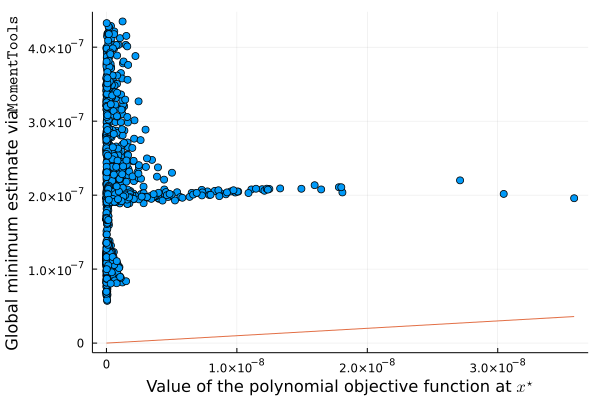

In [75]:
scatter(obj_z_exact, glob_obj_min, label=nothing)
lower = min(minimum(obj_z_exact), minimum(glob_obj_min))
higher = maximum(obj_z_exact)
plot!([lower, higher], [lower, higher], label=nothing)
xlabel!("Value of the polynomial objective function at " * L"x^{\star}")
ylabel!("Global minimum estimate via" * L"\texttt{MomentTools}")

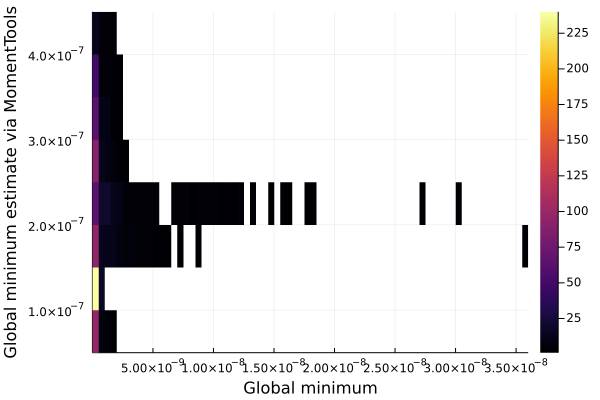

In [76]:
histogram2d(obj_z_exact, glob_obj_min)
xlabel!("Global minimum")
ylabel!("Global minimum estimate via MomentTools")

### Checking accuracy of the Magnus approximatiom

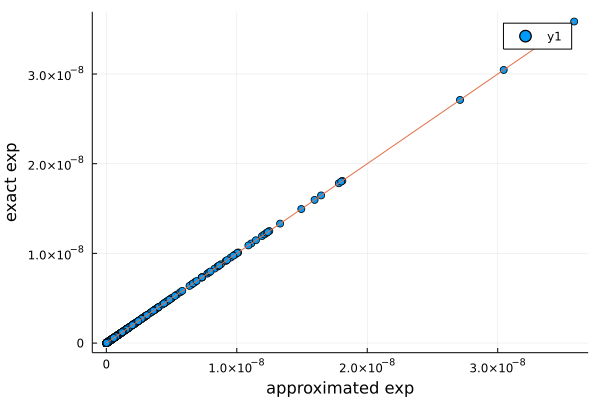

In [22]:
scatter(obj_z_exact, norm_U_target_minus_expΩ_min_z .^ 2)
lower = min(minimum(obj_z_exact), minimum(norm_U_target_minus_expΩ_min_z .^ 2))
higher = max(maximum(obj_z_exact), maximum(norm_U_target_minus_expΩ_min_z .^ 2))
plot!([lower, higher], [lower, higher], label=nothing)
xlabel!("approximated exp")
ylabel!("exact exp")